In [1]:
# plotting
import matplotlib.pyplot as plt

# image processing
import cv2

# opening files and paths
import os

import time

%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from shapely.geometry import CAP_STYLE, JOIN_STYLE

'''
CUSTOM MODULES
'''
# import utility functions
from shapely_conversion import convert
from shapely_utilities import *

# import spiral generation
import spiral as S
import fermat_spiral as FS

# optimization module
from optimization import optimization

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None, endpoints=False, intersections=False):
    
    rest = []
    
    for path in total_path:
        
        if type(path) is list:
            plot_path(path, color)
            if intersections:
                for i in self_intersections_binary(LineString(path)):
                    pyplot.scatter(i.x,i.y, c='red')
                
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [6]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 5

# filename of image to process
filename = 'files/wolf.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE, optimize=True, simplify=1)

results = FS.execute(polygons, distance, connected=True, boundaries=0)

plot_recursive_path(results, intersections=True)

plt.gca().invert_yaxis()


True


In [70]:
from metrics import Metrics

measurer = Metrics(segments=True, commands=True, curvature=False, underfill=True, overfill=True)

True
	Optimize: 1.6747422218322754
1


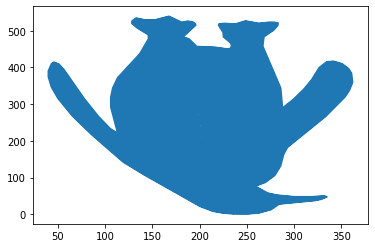

2


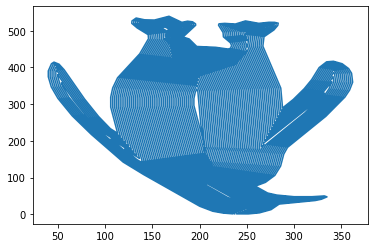

3


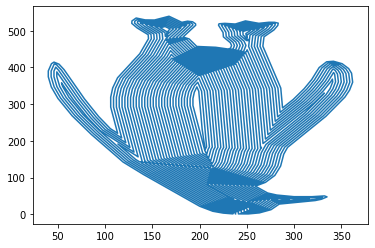

4


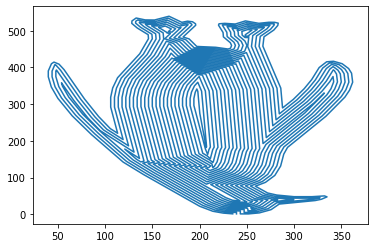

5


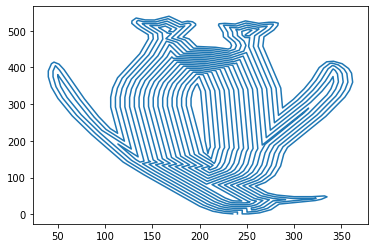

6


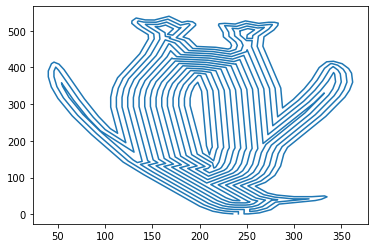

7


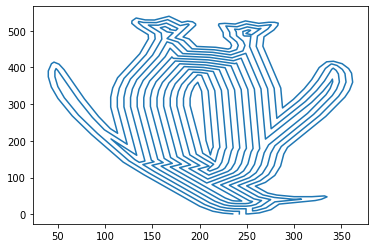

8


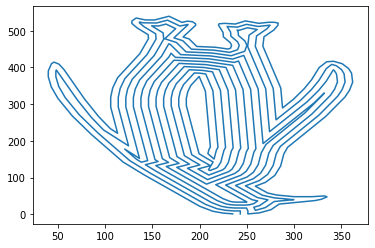

9


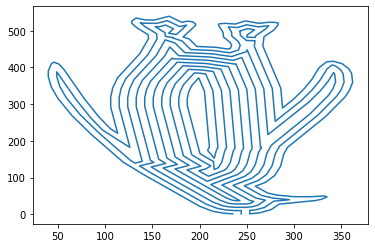

In [71]:
'''
Test different fills
'''

%matplotlib inline

metrics = []

# filename of image to process
filename = 'files/penguin.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

polygons = generate_polygons(image, True, simplify=1)

for i in range(1,10):
    print(i)
    results = FS.execute(polygons, i, connected=True)
    plot_recursive_path(results)
    pyplot.show()
    metrics.append(measurer.measure(results, "CFS", i, polygons))

In [73]:
'''
Converting results to dataframe
'''
import pandas as pd

data = pd.DataFrame(metrics)

data["Underfill"] *= 100
data["Overfill"] *= 100

data

,Method,Distance,Segments,Commands,Curvature,Underfill,Overfill
0,CFS,1,2,3110,NaN,0.295803,0.539583
1,CFS,2,2,1567,NaN,0.834755,0.765682
2,CFS,3,2,1055,NaN,0.967076,1.341880
3,CFS,4,2,808,NaN,0.984132,2.105343
4,CFS,5,2,645,NaN,1.939328,-0.899284
5,CFS,6,2,549,NaN,2.137473,2.651364
6,CFS,7,2,474,NaN,2.852117,0.937674
7,CFS,8,2,407,NaN,4.106468,2.831171
8,CFS,9,2,375,NaN,3.882294,1.386734


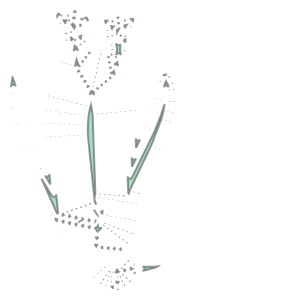

In [54]:
'''
Display the underfill areas (sanity check)
'''

from shapely.geometry import MultiPolygon

path_areas = [LineString(path).buffer(9/2+0.000001) for path in results]
MultiPolygon(polygons).difference(MultiPolygon(path_areas))

In [43]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            
            if not b:
                print("EMPTY!")
            output.append(simplify_tree(b))
            
    return ["X"] + output